In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/traffic-sign-classification

Mounted at /content/drive
/content/drive/MyDrive/traffic-sign-classification


In [3]:
# module imports
import pickle
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from keras.utils.np_utils import to_categorical

In [ ]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs.git
!ls german-traffic-signs

Cloning into 'german-traffic-signs'...
^C
ls: cannot access 'german-traffic-signs': No such file or directory


In [ ]:
# get training, validation, and testing data
with open('german-traffic-signs/train.p','rb') as f:
  training_data = pickle.load(f)

with open('german-traffic-signs/valid.p','rb') as f:
  validation_data = pickle.load(f)

with open('german-traffic-signs/test.p','rb') as f:
  testing_data = pickle.load(f)

In [ ]:
train_imgs, train_labels = training_data['features'], training_data['labels']
val_imgs, val_labels = validation_data['features'], validation_data['labels']
test_imgs, test_labels = testing_data['features'], testing_data['labels']

In [ ]:
classes = pd.read_csv('german-traffic-signs/signnames.csv')

Image Shapes: 32x32 with 3 channels (RGB)

34799 training images \\
4410 validation images \\
12630 testing images \\

Output: 43 Classification Labels

41
(34799, 32, 32, 3) (34799,)


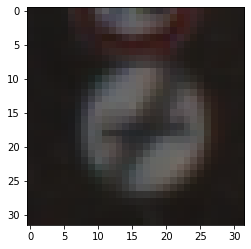

In [ ]:
plt.imshow(train_imgs[0])
print(train_labels[0])
print(train_imgs.shape, train_labels.shape)

In [ ]:
train_labels_cat = to_categorical(train_labels, 43)
val_labels_cat = to_categorical(val_labels, 43)
test_labels_cat = to_categorical(test_labels, 43)

# train_labels_cat = np.expand_dims(train_labels_cat, axis=0)

In [ ]:
tf_train_data = tf.data.Dataset.from_tensor_slices((train_imgs, train_labels_cat)).batch(400)
tf_val_data = tf.data.Dataset.from_tensor_slices((val_imgs, val_labels_cat)).batch(400)
tf_test_data = tf.data.Dataset.from_tensor_slices((test_imgs, test_labels_cat)).batch(400)

**Creating Model**

In [ ]:
# adding data augmentation layers to start of model
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"), # horizontal flipping to random 50% of images
    layers.RandomRotation(0.15), # rotates input images by [-15%, 15%]
    layers.RandomZoom(0.2), # zooms in or out of image by [-20%, 20%]
  ]
)

inputs = keras.Input(shape=(32, 32, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
# x = layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
# x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x) 
# x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(43, activation="softmax")(x) # because it is multi classification
model = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 32, 32, 3)         0         
                                                                 
 conv2d_49 (Conv2D)          (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                     

In [ ]:
callbacks = [
  keras.callbacks.ModelCheckpoint(
      filepath="with_relu.keras",
      monitor="val_loss"
  )
]

history = model.fit(train_imgs, train_labels_cat, epochs=30, 
                    validation_data=(val_imgs, val_labels_cat), callbacks=callbacks)

Epoch 1/30
1088/1088 [==============================] - 8s 7ms/step - loss: 1.2608 - accuracy: 0.6429 - val_loss: 0.3432 - val_accuracy: 0.9084
Epoch 2/30
1088/1088 [==============================] - 6s 6ms/step - loss: 0.2780 - accuracy: 0.9164 - val_loss: 0.2529 - val_accuracy: 0.9354
Epoch 3/30
1088/1088 [==============================] - 6s 6ms/step - loss: 0.1604 - accuracy: 0.9512 - val_loss: 0.1338 - val_accuracy: 0.9558
Epoch 4/30
1088/1088 [==============================] - 6s 6ms/step - loss: 0.1049 - accuracy: 0.9682 - val_loss: 0.1216 - val_accuracy: 0.9612
Epoch 5/30
1088/1088 [==============================] - 6s 6ms/step - loss: 0.0867 - accuracy: 0.9749 - val_loss: 0.1337 - val_accuracy: 0.9687
Epoch 6/30
1088/1088 [==============================] - 6s 5ms/step - loss: 0.0644 - accuracy: 0.9801 - val_loss: 0.1234 - val_accuracy: 0.9678
Epoch 7/30
1088/1088 [==============================] - 6s 6ms/step - loss: 0.0607 - accuracy: 0.9816 - val_loss: 0.1281 - val_accuracy:

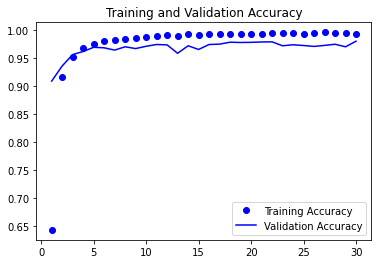

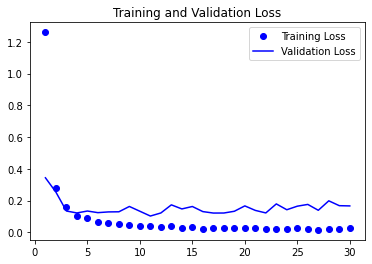

In [ ]:
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy)+1)
plt.plot(epochs, accuracy, "bo", label="Training Accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [ ]:
test_model = keras.models.load_model("with_relu.keras")
test_loss, test_acc = test_model.evaluate(test_imgs, test_labels_cat)
print(f"Test accuracy: {test_acc:.4f}")

395/395 [==============================] - 3s 7ms/step - loss: 0.3250 - accuracy: 0.9641
Test accuracy: 0.9641


In [6]:
mod = keras.models.load_model("mixed_model.keras")
mod.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 rescaling_8 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_35 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 conv2d_36 (Conv2D)          (None, 28, 28, 32)        25632     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 14, 14, 64)        18496     
                                                           